In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# from sklearn.metrics import brier_score_loss

!pip install tensorflow_decision_forests
# TF-DF requires Tensorflow < 2.15 or tf_keras
!pip install tf_keras
!pip install wurlitzer

import tensorflow as tf
import tensorflow_decision_forests as tfdf
import tf_keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 53.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 71.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 59.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 80.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 54.0 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Suc

With Round 1 tourney games weighted 2x season games: weighted accuracy = 0.7505, test Brier score = 0.164655

In [ ]:
def brier_score(pred_prob, ytrue):
  return np.mean((pred_prob - ytrue)**2)

In [ ]:
# Read in data and clean it up for testing (i.e. use season averages)
DATA_PATH = 'drive/MyDrive/march_madness/2024/'

df = pd.read_csv(DATA_PATH + 'final_data_all_games_2003-2023.csv')

print(df.shape)
df.head()

(361696, 18)


,Season,TeamIDA,TeamIDB,SeedA,SeedB,Weights,WinRatio14A,OffEffA,DefEffA,EFTA,WinRatioA,WinRatio14B,OffEffB,DefEffB,EFTB,WinRatioB,ScoreDiff,WinA
0,2003,1104,1328,10.0,1.0,1.0,0.500000,107.677056,101.630338,0.475785,0.607143,0.800000,113.389612,96.445994,0.512124,0.800000,6,1
1,2003,1272,1393,7.0,3.0,1.0,0.750000,109.889666,97.004974,0.498337,0.793103,0.750000,114.375065,100.143566,0.515151,0.827586,7,1
2,2003,1266,1437,3.0,17.0,1.0,0.500000,120.051019,103.191105,0.536723,0.821429,0.000000,105.369921,102.668103,0.480911,0.500000,12,1
3,2003,1296,1457,17.0,17.0,1.0,0.400000,107.258210,107.247397,0.520538,0.548387,0.500000,104.453154,100.312975,0.500567,0.642857,6,1
4,2003,1400,1208,1.0,17.0,1.0,0.666667,115.644595,100.740654,0.495827,0.785714,0.666667,117.069584,108.587823,0.520926,0.703704,6,1


In [ ]:
def split_dataset(dataset, test_ratio=0.30):
  """Splits a panda dataframe in two."""
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

label = 'WinA'
to_drop = ['Season', 'TeamIDB', 'ScoreDiff']
train, test = split_dataset(df.drop(columns=to_drop), test_ratio=0.3)

print(train.shape)
train.head()

(252586, 15)


,TeamIDA,SeedA,SeedB,Weights,WinRatio14A,OffEffA,DefEffA,EFTA,WinRatioA,WinRatio14B,OffEffB,DefEffB,EFTB,WinRatioB,WinA
0,1104,10.0,1.0,1.0,0.500000,107.677056,101.630338,0.475785,0.607143,0.800000,113.389612,96.445994,0.512124,0.800000,1
1,1272,7.0,3.0,1.0,0.750000,109.889666,97.004974,0.498337,0.793103,0.750000,114.375065,100.143566,0.515151,0.827586,1
3,1296,17.0,17.0,1.0,0.400000,107.258210,107.247397,0.520538,0.548387,0.500000,104.453154,100.312975,0.500567,0.642857,1
6,1161,14.0,17.0,1.0,0.833333,111.685478,110.275473,0.548663,0.566667,0.000000,99.576183,111.567101,0.494368,0.310345,1
10,1166,6.0,17.0,1.0,1.000000,118.566346,96.739284,0.567455,0.878788,0.666667,100.034570,99.342180,0.467874,0.518519,1


In [ ]:
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train, label=label, weight='Weights')
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test, label=label, weight='Weights')

### Top ranking hyperparameter benchmark

In [ ]:
model = tfdf.keras.GradientBoostedTreesModel(verbose=2, loss='MULTINOMIAL_LOG_LIKELIHOOD', hyperparameter_template='benchmark_rank1@v1')
model.compile(metrics=['accuracy'], weighted_metrics=['accuracy'])
model.fit(train_ds)
model.evaluate(test_ds)

Resolve hyper-parameter template "benchmark_rank1@v1" to "benchmark_rank1@v1" -> {'growing_strategy': 'BEST_FIRST_GLOBAL', 'categorical_algorithm': 'RANDOM', 'split_axis': 'SPARSE_OBLIQUE', 'sparse_oblique_normalization': 'MIN_MAX', 'sparse_oblique_num_projections_exponent': 1.0}.
Use 2 thread(s) for training
Use /tmp/tmpngxajz8t as temporary training directory
Reading training dataset...
Training tensor examples:
Features: {'TeamIDA': <tf.Tensor 'data:0' shape=(None,) dtype=int64>, 'SeedA': <tf.Tensor 'data_1:0' shape=(None,) dtype=float64>, 'SeedB': <tf.Tensor 'data_2:0' shape=(None,) dtype=float64>, 'WinRatio14A': <tf.Tensor 'data_3:0' shape=(None,) dtype=float64>, 'OffEffA': <tf.Tensor 'data_4:0' shape=(None,) dtype=float64>, 'DefEffA': <tf.Tensor 'data_5:0' shape=(None,) dtype=float64>, 'EFTA': <tf.Tensor 'data_6:0' shape=(None,) dtype=float64>, 'WinRatioA': <tf.Tensor 'data_7:0' shape=(None,) dtype=float64>, 'WinRatio14B': <tf.Tensor 'data_8:0' shape=(None,) dtype=float64>, 'OffE

[INFO 24-03-08 04:30:42.4202 UTC kernel.cc:771] Start Yggdrasil model training
[INFO 24-03-08 04:30:42.4202 UTC kernel.cc:772] Collect training examples
[INFO 24-03-08 04:30:42.4202 UTC kernel.cc:785] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

[INFO 24-03-08 04:30:42.4208 UTC kernel.cc:391] Number of batches: 253
[INFO 24-03-08 04:30:42.4208 UTC kernel.cc:392] Number of examples: 252586
[INFO 24-03-08 04:30:42.4701 UTC kernel.cc:792] Training dataset:
Number of records: 252586
Number of columns: 15

Number of columns by type:
	NUMERICAL: 14 (93.3333%)
	CATEGORICAL: 1 (6.66667%)

Columns:

NUMERICAL: 14 (93.3333%)
	0: "DefEffA" NUMERICAL num-nas:449 (0.177761%) me

Model trained in 0:01:57.467396
Compiling model...
Model compiled.
110/110 [==============================] - 3s 23ms/step - loss: 0.0000e+00 - accuracy: 0.7501 - weighted_accuracy: 0.7326


[0.0, 0.75005042552948, 0.7326011061668396]

In [ ]:
model.summary()

Model: "gradient_boosted_trees_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (13):
	DefEffA
	DefEffB
	EFTA
	EFTB
	OffEffA
	OffEffB
	SeedA
	SeedB
	TeamIDA
	WinRatio14A
	WinRatio14B
	WinRatioA
	WinRatioB

Trained with weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1.     "DefEffA"  0.232991 ################
    2.     "DefEffB"  0.225757 ##############
    3.     "OffEffB"  0.214846 ###########
    4.        "EFTA"  0.209907 ##########
    5.     "OffEffA"  0.209385 ##########
    6.        "EFTB"  0.200408 ########
    7.       "SeedA"  0.197751 #######
    8.   "WinRatioA"  0.188029 #####
    9.   "WinRatioB"  0.181426 ####
   10.       "SeedB" 

Text(0, 0.5, 'Logloss (out-of-bag)')

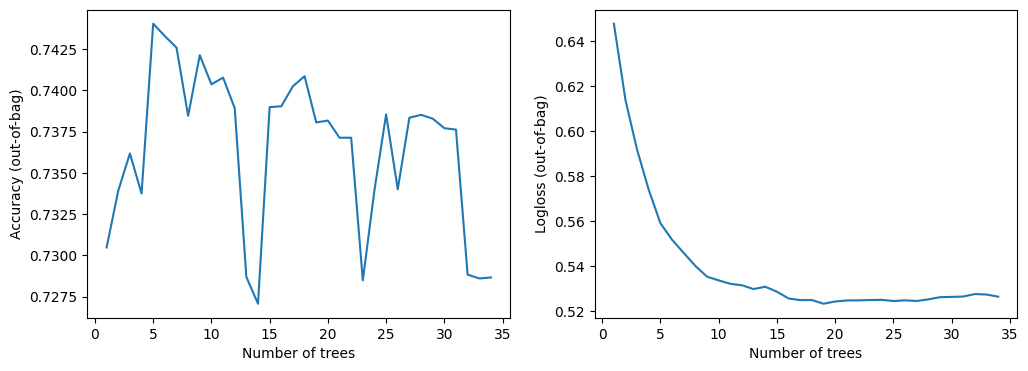

In [ ]:
logs = model.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

In [ ]:
print('Training score')
ypreds = model.predict(train_ds)
train_score = brier_score(ypreds[:,0], train.WinA)
print('\t', train_score)

print('Testing score')
ypreds = model.predict(test_ds)
test_score = brier_score(ypreds[:,0], test.WinA)
print('\t', test_score)

Training score
253/253 [==============================] - 7s 29ms/step
	 0.16505721124226144
Testing score
110/110 [==============================] - 3s 23ms/step
	 0.16720664095657797


### Hyperparameter tuner

In [ ]:
tuner = tfdf.tuner.RandomSearch(num_trials=10, use_predefined_hps=True)

model = tfdf.keras.GradientBoostedTreesModel(tuner=tuner)
model.compile(metrics=['accuracy'], weighted_metrics=['accuracy'])
model.fit(train_ds)
model.evaluate(test_ds)

Use /tmp/tmp2iszyg0a as temporary training directory
Reading training dataset...
Training dataset read in 0:00:03.549430. Found 252586 examples.
Training model...
Model trained in 0:52:19.197476
Compiling model...
Model compiled.
110/110 [==============================] - 6s 49ms/step - loss: 0.0000e+00 - accuracy: 0.7510 - weighted_accuracy: 0.7432


[0.0, 0.7509852647781372, 0.7431920170783997]

In [ ]:
tuning_logs = model.make_inspector().tuning_logs()
tuning_logs[tuning_logs.best].iloc[0]

score                                                -1.03437
evaluation_time                                   3134.942053
best                                                     True
split_axis                                     SPARSE_OBLIQUE
sparse_oblique_projection_density_factor                  2.0
sparse_oblique_normalization                             NONE
sparse_oblique_weights                                 BINARY
categorical_algorithm                                  RANDOM
growing_strategy                            BEST_FIRST_GLOBAL
max_num_nodes                                             128
sampling_method                                        RANDOM
subsample                                                 0.8
shrinkage                                                0.02
min_examples                                               10
use_hessian_gain                                         true
num_candidate_attributes_ratio                            0.9
Name: 0,

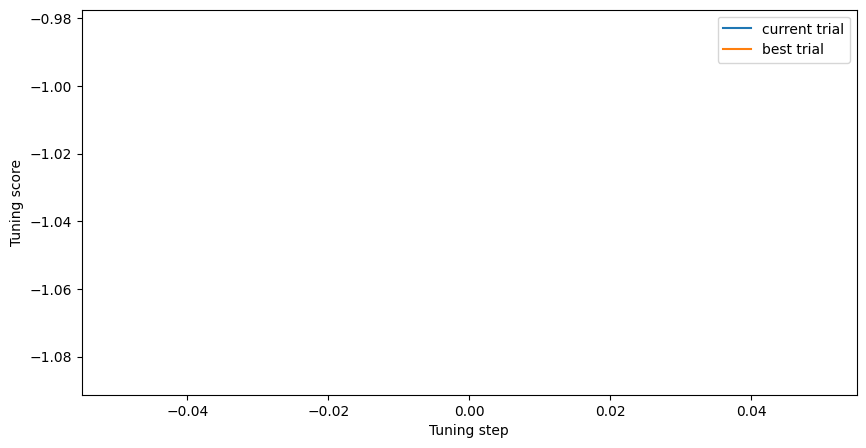

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(tuning_logs["score"], label="current trial")
plt.plot(tuning_logs["score"].cummax(), label="best trial")
plt.xlabel("Tuning step")
plt.ylabel("Tuning score")
plt.legend()
plt.show()